In [1]:
import pandas as pd
import os
import ast
import zipfile
import matplotlib
from neo4j import GraphDatabase
import configparser
import textwrap

# Data Preparation and Neo4j Ingest

In this notebook we format the 
[MIND-Small Dataset](https://msnews.github.io/#:~:text=name%20this%20dataset-,MIND-small,-.%20The%20training%20and)[[1]](#1)
training and validation sets and load them into a Neo4j graph. The work is divided into two primary sections in this notebook:

1. __[Prepare Data (Extract & Transform)](#prepare-data)__
2. __[Load Data Into Neo4j](#load-data)__

__To run this notebook please do the following:__
 - Download the training and validation sets from [MIND-Small Dataset](https://msnews.github.io/#:~:text=name%20this%20dataset-,MIND-small,-.%20The%20training%20and) and place into the `SOURCE_DATA_PATH` set in the below [Setup Parameters](#set-up) section.

 - Ensure the `NEO4J_IMPORT_DIR`, `NEO4j_IMPORT_PATH`, and `NEO4J_PROPERTIES_FILE` are set correctly for your environemnt in the below [Setup Parameters](#set-up) section.

__Other Prerequisites:__
- Neo4j >= 4.3.x. This notebook was tested with [Neo4j Desktop](https://neo4j.com/download-center/#desktop) and should work for other on-prem installations.
- [APOC library](https://neo4j.com/labs/apoc/4.3/installation/).  This project was tested with APOC 4.3. 
- Notebook tested with Python=3.8

<a id="1">[1]</a>
Fangzhao Wu, Ying Qiao, Jiun-Hung Chen, Chuhan Wu, Tao Qi, Jianxun Lian, Danyang Liu, Xing Xie, Jianfeng Gao,
 Winnie Wu and Ming Zhou. MIND: A Large-scale Dataset for News Recommendation. ACL 2020.

## <a id="set-up">Setup Parameters</a>

#### Directory Settings

In [2]:
# The directory where MINDsmall_train.zip and MINDsmall_dev.zip exist
SOURCE_DATA_PATH = './data/'

`NEO4J_IMPORT_DIR` sets the the directory to put formatted csvs in for Neo4j load.
File locations for each OS are listed in the [Neo4j Operations Manual](https://neo4j.com/docs/operations-manual/current/configuration/file-locations). We recommend putting files in Neo4j’s `import` directory, as it keeps the environment secure. However, if you need to access files in other locations, you can find out which setting to alter in our [manual](https://neo4j.com/docs/cypher-manual/current/clauses/load-csv/#query-load-csv-introduction).

In [3]:
NEO4J_IMPORT_DIR = '/Users/zachblumenfeld/Library/Application Support/Neo4j Desktop/Application/relate-data/' + \
    'dbmss/dbms-fa90436a-1b9d-410d-a552-6191a6f481af/import'

`NEO4j_IMPORT_PATH` sets the path to use during CSV load. This will be 'file:///' by default and aligns with the local Neo4j `import` directory setup. 
See https://neo4j.com/developer/guide-import-csv/#_reading_csv_files for more details and customization

In [4]:
NEO4j_IMPORT_PATH = 'file:///'

#### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
DATABASE=<database name, is 'neo4j' by default>
HOST=<host uri>

```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
DATABASE = 'neo4j'
PASSWORD = 'password'
```

In [5]:
NEO4J_PROPERTIES_FILE = None # '/Users/zachblumenfeld/devtools/aura-news-demo.ini'

## <a id="prepare-data">Prepare Data (Extract & Transform)</a>
In this section we extract and transform the source data into formatted csv files to prepare for [loading into Neo4j](#load-data).
We will create the following csv files.  There are quite a few, but generally I find it is easier for heterogeneous
graphs with many attributes to split up more files than try and merge into fewer.

__News related graph elements__
1. `news.csv`: Nodes representing news articles
2. `categories.csv`: Nodes representing news article categories
3. `sub-category-of-category.csv`: Relationships representing the subcategories underneath each category
4. `news-belongs-to-sub-category.csv`: Relationships representing each news belonging to a primary subcategory
5. `entities.csv`: Nodes representing WikiData entities extracted from the news articles by Microsoft
6. `entity-encoding.csv`: TransE embeddings/encodings calculated by microsoft to be merged with the entity nodes
7. `news-title-about.csv`: Relationship representing a news title referencing a wikiData entity
8. `news-abstract-about.csv`: Relationship representing a news abstract referencing a wikiData entity

__User and impression related graph elements__
1. `users.csv`: Nodes representing anonymized users
2. `clicks.csv`: Relationships representing users clicking on a News article from an impression.
3. `did-not-clicks.csv`: Relationships representing users not clicking on a News article from an impression.
4. `historic-clicks.csv`: Relationships representing users having historically clcked an article according to the
impression record.
5. `news-approxTime.csv`: The minimum known impression time for news articles.  This will be merged with the News nodes.
Some news article, in fact the majority, are not included in any impression within our sample, they are only referenced
historically and thus this field will be null for them.

### Unzip Source data

In [6]:
#training set data
with zipfile.ZipFile( SOURCE_DATA_PATH + "MINDsmall_train.zip","r") as zip_ref:
    zip_ref.extractall(SOURCE_DATA_PATH + "train")

In [7]:
# validation set data
with zipfile.ZipFile( SOURCE_DATA_PATH + "MINDsmall_dev.zip","r") as zip_ref:
    zip_ref.extractall(SOURCE_DATA_PATH + "validate")

### News Related Graph Elements

In [8]:
col_names = ['newsId', 'category', 'subcategory', 'title', 'abstract', 'url', 'titleEntities','abstractEntities']
news_train_df = pd.read_csv('./data/train/news.tsv', sep = '\t', header = None, names = col_names)
news_validate_df = pd.read_csv('./data/validate/news.tsv', sep = '\t', header = None, names = col_names)

In [9]:
news_and_entities_df = pd.concat([news_train_df, news_validate_df],ignore_index=True).drop_duplicates()

#### News Nodes

In [10]:
news_df = news_and_entities_df.drop(columns = ['titleEntities', 'abstractEntities'])

In [11]:
# clean up quotes for easier csv formatting
news_df.abstract = news_df.abstract.str.replace('"', "'")
news_df.title = news_df.title.str.replace('"', "'")

In [12]:
# a couple manual fixes
news_df.loc[news_df.newsId == 'N18259', 'abstract'] = "He'll be in better shape physically and he'll be in a better place mentally too,'' coach Freddie Kitchens said of Mayfield"
news_df.loc[news_df.newsId == 'N18259', 'url'] = 'https://assets.msn.com/labs/mind/AAIPbTZ.html'

In [13]:
news_df.to_csv(f'{NEO4J_IMPORT_DIR}/news.csv', index = False)
news_df

,newsId,category,subcategory,title,abstract,url
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html
...,...,...,...,...,...,...
93675,N2292,news,newspolitics,House investigators release more impeachment t...,House Democrats released new transcripts of Tr...,https://assets.msn.com/labs/mind/BBWsb2c.html
93677,N27291,lifestyle,lifestylebuzz,Mural in Downtown S.F. Depicts Swedish Teen Cl...,The newest addition to the San Francisco skyli...,https://assets.msn.com/labs/mind/BBWsbQg.html
93680,N52871,news,newsworld,Residents of Mexican town struggle with fear a...,A mother and two sons were laid to rest in han...,https://assets.msn.com/labs/mind/BBWscU8.html
93681,N36658,news,newsus,Apartments for rent in Minneapolis: What will ...,Curious just how far your dollar goes in Minne...,https://assets.msn.com/labs/mind/BBWscWw.html


#### Category/Subcategory Nodes and Relationships

In [14]:
sub_category_rel_df = news_df[['newsId','category', 'subcategory']]
sub_category_rel_df.to_csv(f'{NEO4J_IMPORT_DIR}/news-belongs-to-sub-category.csv', index = False)
sub_category_rel_df

,newsId,category,subcategory
0,N55528,lifestyle,lifestyleroyals
1,N19639,health,weightloss
2,N61837,news,newsworld
3,N53526,health,voices
4,N38324,health,medical
...,...,...,...
93675,N2292,news,newspolitics
93677,N27291,lifestyle,lifestylebuzz
93680,N52871,news,newsworld
93681,N36658,news,newsus


In [15]:
category_rel_df = news_df[['category','subcategory']].drop_duplicates()
category_rel_df.to_csv(f'{NEO4J_IMPORT_DIR}/sub-category-of-category.csv', index = False)
category_rel_df

,category,subcategory
0,lifestyle,lifestyleroyals
1,health,weightloss
2,news,newsworld
3,health,voices
4,health,medical
...,...,...
60344,lifestyle,lifestyletravel
63829,weather,photos
68278,games,games-news
83609,news,newsvideos


In [16]:
category_df = category_rel_df[['category']].drop_duplicates()
category_df.to_csv(f'{NEO4J_IMPORT_DIR}/categories.csv', index = False)
category_df

,category
0,lifestyle
1,health
2,news
5,sports
6,weather
8,entertainment
11,autos
17,travel
26,foodanddrink
32,tv


In [17]:
sub_category_df = category_rel_df[['subcategory']]
sub_category_df

,subcategory
0,lifestyleroyals
1,weightloss
2,newsworld
3,voices
4,medical
...,...
60344,lifestyletravel
63829,photos
68278,games-news
83609,newsvideos


In [18]:
#we have some subcategory duplicates
dup_sub_categories = sub_category_df.subcategory[sub_category_df.subcategory.duplicated()].tolist()
category_rel_df.loc[category_rel_df.subcategory.isin(dup_sub_categories)].sort_values('subcategory')

,category,subcategory
49779,kids,animals
162,video,animals
25127,finance,causes
139,lifestyle,causes
298,health,causes
24144,news,causes
13039,travel,holidays
1189,lifestyle,holidays
25364,music,humor
1661,tv,humor


Due to the above duplicates, let's define subcategories by complete hierarchy i.e. our
`subactegory-value = <category>-<subcategory>`. We can merge the string during the load process. This means that
`sub_category_rel_df` will serve as both the relationships and node source for sub category.

#### Prepare Title WikiData Entities

In [19]:
raw_title_entity_df = news_and_entities_df.drop(
    columns = ['category', 'subcategory', 'title', 'abstract', 'url', 'abstractEntities'])

In [20]:
def get_entities(entity_string):
    entity_list = []
    if not pd.isna(entity_string):
        entity_list = ast.literal_eval(entity_string)
    return entity_list

raw_title_entity_df['titleEntitiesFormatted'] = raw_title_entity_df.titleEntities.apply(get_entities)
raw_title_entity_df

,newsId,titleEntities,titleEntitiesFormatted
0,N55528,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...","[{'Label': 'Prince Philip, Duke of Edinburgh',..."
1,N19639,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{'Label': 'Adipose tissue', 'Type': 'C', 'Wik..."
2,N61837,[],[]
3,N53526,[],[]
4,N38324,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{'Label': 'Skin tag', 'Type': 'C', 'WikidataI..."
...,...,...,...
93675,N2292,[],[]
93677,N27291,"[{""Label"": ""Greta Thunberg"", ""Type"": ""N"", ""Wik...","[{'Label': 'Greta Thunberg', 'Type': 'N', 'Wik..."
93680,N52871,"[{""Label"": ""Mexico, New York"", ""Type"": ""G"", ""W...","[{'Label': 'Mexico, New York', 'Type': 'G', 'W..."
93681,N36658,"[{""Label"": ""Minneapolis"", ""Type"": ""G"", ""Wikida...","[{'Label': 'Minneapolis', 'Type': 'G', 'Wikida..."


In [21]:
raw_title_entity_df = raw_title_entity_df.explode('titleEntitiesFormatted', ignore_index=True)
raw_title_entity_df = raw_title_entity_df.drop(columns = ['titleEntities']).dropna().reset_index(drop=True)
raw_title_entity_df

,newsId,titleEntitiesFormatted
0,N55528,"{'Label': 'Prince Philip, Duke of Edinburgh', ..."
1,N55528,"{'Label': 'Charles, Prince of Wales', 'Type': ..."
2,N55528,"{'Label': 'Elizabeth II', 'Type': 'P', 'Wikida..."
3,N19639,"{'Label': 'Adipose tissue', 'Type': 'C', 'Wiki..."
4,N38324,"{'Label': 'Skin tag', 'Type': 'C', 'WikidataId..."
...,...,...
77025,N53002,"{'Label': 'Oakland Raiders', 'Type': 'O', 'Wik..."
77026,N53002,"{'Label': 'Twitter', 'Type': 'O', 'WikidataId'..."
77027,N27291,"{'Label': 'Greta Thunberg', 'Type': 'N', 'Wiki..."
77028,N52871,"{'Label': 'Mexico, New York', 'Type': 'G', 'Wi..."


In [22]:
title_ent_df = pd.json_normalize(raw_title_entity_df.titleEntitiesFormatted)
title_ent_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms
0,"Prince Philip, Duke of Edinburgh",P,Q80976,1.00,[48],[Prince Philip]
1,"Charles, Prince of Wales",P,Q43274,1.00,[28],[Prince Charles]
2,Elizabeth II,P,Q9682,0.97,[11],[Queen Elizabeth]
3,Adipose tissue,C,Q193583,1.00,[20],[Belly Fat]
4,Skin tag,C,Q3179593,1.00,[18],[Skin Tags]
...,...,...,...,...,...,...
77025,Oakland Raiders,O,Q324523,1.00,[36],[Raiders]
77026,Twitter,O,Q918,1.00,[0],[Twitter]
77027,Greta Thunberg,N,Q56434717,1.00,[61],[Greta Thunberg]
77028,"Mexico, New York",G,Q478556,1.00,[13],[Mexican town]


In [23]:
title_entity_rel_df = pd.concat([title_ent_df, raw_title_entity_df[['newsId']]], axis=1)
title_entity_rel_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms,newsId
0,"Prince Philip, Duke of Edinburgh",P,Q80976,1.00,[48],[Prince Philip],N55528
1,"Charles, Prince of Wales",P,Q43274,1.00,[28],[Prince Charles],N55528
2,Elizabeth II,P,Q9682,0.97,[11],[Queen Elizabeth],N55528
3,Adipose tissue,C,Q193583,1.00,[20],[Belly Fat],N19639
4,Skin tag,C,Q3179593,1.00,[18],[Skin Tags],N38324
...,...,...,...,...,...,...,...
77025,Oakland Raiders,O,Q324523,1.00,[36],[Raiders],N53002
77026,Twitter,O,Q918,1.00,[0],[Twitter],N53002
77027,Greta Thunberg,N,Q56434717,1.00,[61],[Greta Thunberg],N27291
77028,"Mexico, New York",G,Q478556,1.00,[13],[Mexican town],N52871


array([[<AxesSubplot:title={'center':'Confidence'}>]], dtype=object)

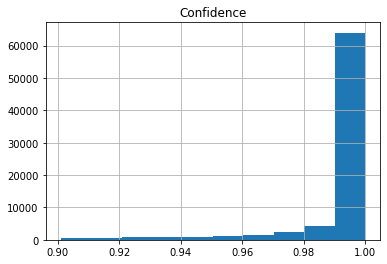

In [24]:
# Note that the Confidence scores seem to be skewed towards 1.0 with a cutoff at around 0.9...
# No low confidence included
title_entity_rel_df.hist('Confidence')

In [25]:
# we will extract the title entities and combine with the abstract ones below before writing
title_entity_df = title_entity_rel_df \
    .drop(columns = ['Confidence', 'OccurrenceOffsets', 'SurfaceForms', 'newsId']).drop_duplicates()
title_entity_df

,Label,Type,WikidataId
0,"Prince Philip, Duke of Edinburgh",P,Q80976
1,"Charles, Prince of Wales",P,Q43274
2,Elizabeth II,P,Q9682
3,Adipose tissue,C,Q193583
4,Skin tag,C,Q3179593
...,...,...,...
76980,"Pierce County, Washington",G,Q156459
76981,Sound Transit,O,Q3965367
76988,Sean Casey (baseball),P,Q7440875
76990,Side platform,C,Q2735706


#### Prepare Abstract WikiData Entities

In [26]:
raw_abstract_entity_df = news_and_entities_df.drop(
    columns = ['category', 'subcategory', 'title', 'abstract', 'url', 'titleEntities'])

In [27]:
def get_entities(entity_string):
    entity_list = []
    if not pd.isna(entity_string):
        entity_list = ast.literal_eval(entity_string)
    return entity_list

raw_abstract_entity_df['abstractEntitiesFormatted'] = raw_abstract_entity_df.abstractEntities.apply(get_entities)
raw_abstract_entity_df

,newsId,abstractEntities,abstractEntitiesFormatted
0,N55528,[],[]
1,N19639,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{'Label': 'Adipose tissue', 'Type': 'C', 'Wik..."
2,N61837,"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...","[{'Label': 'Ukraine', 'Type': 'G', 'WikidataId..."
3,N53526,"[{""Label"": ""National Basketball Association"", ...","[{'Label': 'National Basketball Association', ..."
4,N38324,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{'Label': 'Skin tag', 'Type': 'C', 'WikidataI..."
...,...,...,...
93675,N2292,"[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...","[{'Label': 'Donald Trump', 'Type': 'P', 'Wikid..."
93677,N27291,"[{""Label"": ""Greta Thunberg"", ""Type"": ""N"", ""Wik...","[{'Label': 'Greta Thunberg', 'Type': 'N', 'Wik..."
93680,N52871,"[{""Label"": ""Mexico"", ""Type"": ""G"", ""WikidataId""...","[{'Label': 'Mexico', 'Type': 'G', 'WikidataId'..."
93681,N36658,"[{""Label"": ""Minneapolis"", ""Type"": ""G"", ""Wikida...","[{'Label': 'Minneapolis', 'Type': 'G', 'Wikida..."


In [28]:
raw_abstract_entity_df = raw_abstract_entity_df.explode('abstractEntitiesFormatted', ignore_index=True)
raw_abstract_entity_df = raw_abstract_entity_df.drop(columns = ['abstractEntities']).dropna().reset_index(drop=True)
raw_abstract_entity_df

,newsId,abstractEntitiesFormatted
0,N19639,"{'Label': 'Adipose tissue', 'Type': 'C', 'Wiki..."
1,N61837,"{'Label': 'Ukraine', 'Type': 'G', 'WikidataId'..."
2,N53526,"{'Label': 'National Basketball Association', '..."
3,N38324,"{'Label': 'Skin tag', 'Type': 'C', 'WikidataId..."
4,N38324,"{'Label': 'Dermatology', 'Type': 'C', 'Wikidat..."
...,...,...
123608,N27291,"{'Label': 'Greta Thunberg', 'Type': 'N', 'Wiki..."
123609,N27291,"{'Label': 'Climate change', 'Type': 'C', 'Wiki..."
123610,N27291,"{'Label': 'San Francisco', 'Type': 'G', 'Wikid..."
123611,N52871,"{'Label': 'Mexico', 'Type': 'G', 'WikidataId':..."


In [29]:
abstract_ent_df = pd.json_normalize(raw_abstract_entity_df.abstractEntitiesFormatted)
abstract_ent_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms
0,Adipose tissue,C,Q193583,1.000,[97],[belly fat]
1,Ukraine,G,Q212,0.946,[87],[Ukraine]
2,National Basketball Association,O,Q155223,1.000,[40],[NBA]
3,Skin tag,C,Q3179593,1.000,[105],[Skin Tags]
4,Dermatology,C,Q171171,1.000,[131],[Dermatologist]
...,...,...,...,...,...,...
123608,Greta Thunberg,N,Q56434717,1.000,[104],[Greta Thunberg]
123609,Climate change,C,Q125928,0.939,[150],[climate change]
123610,San Francisco,G,Q62,0.989,[27],[San Francisco]
123611,Mexico,G,Q96,0.948,[146],[Mexico]


In [30]:
abstract_entity_rel_df = pd.concat([abstract_ent_df, raw_abstract_entity_df[['newsId']]], axis=1)
abstract_entity_rel_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms,newsId
0,Adipose tissue,C,Q193583,1.000,[97],[belly fat],N19639
1,Ukraine,G,Q212,0.946,[87],[Ukraine],N61837
2,National Basketball Association,O,Q155223,1.000,[40],[NBA],N53526
3,Skin tag,C,Q3179593,1.000,[105],[Skin Tags],N38324
4,Dermatology,C,Q171171,1.000,[131],[Dermatologist],N38324
...,...,...,...,...,...,...,...
123608,Greta Thunberg,N,Q56434717,1.000,[104],[Greta Thunberg],N27291
123609,Climate change,C,Q125928,0.939,[150],[climate change],N27291
123610,San Francisco,G,Q62,0.989,[27],[San Francisco],N27291
123611,Mexico,G,Q96,0.948,[146],[Mexico],N52871


array([[<AxesSubplot:title={'center':'Confidence'}>]], dtype=object)

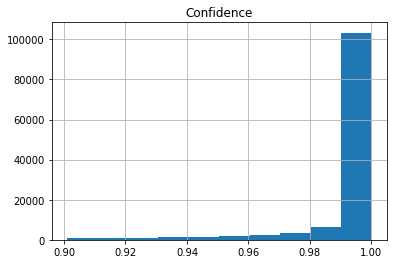

In [31]:
# Note that the Confidence scores seem to be skewed towards 1.0 with a cutoff at around 0.9...
# No low confidence included
abstract_entity_rel_df.hist('Confidence')

In [32]:
abstract_entity_df = abstract_entity_rel_df \
    .drop(columns = ['Confidence', 'OccurrenceOffsets', 'SurfaceForms', 'newsId']).drop_duplicates()
abstract_entity_df

,Label,Type,WikidataId
0,Adipose tissue,C,Q193583
1,Ukraine,G,Q212
2,National Basketball Association,O,Q155223
3,Skin tag,C,Q3179593
4,Dermatology,C,Q171171
...,...,...,...
123570,"Seventh Ward, New Orleans",U,Q7457754
123581,Mike Augustyniak,N,Q60286906
123587,ESPN Radio,O,Q3046168
123588,WatchESPN,M,Q7973037


#### Combine WikiData Entity Info and Write to CSV

In [33]:
entity_df = pd.concat([title_entity_df, abstract_entity_df], ignore_index=True).drop_duplicates()
entity_df

,Label,Type,WikidataId
0,"Prince Philip, Duke of Edinburgh",P,Q80976
1,"Charles, Prince of Wales",P,Q43274
2,Elizabeth II,P,Q9682
3,Adipose tissue,C,Q193583
4,Skin tag,C,Q3179593
...,...,...,...
45584,Beach Boulevard (Jacksonville),S,Q2432642
45585,"Seventh Ward, New Orleans",U,Q7457754
45586,Mike Augustyniak,N,Q60286906
45587,ESPN Radio,O,Q3046168


In [34]:
# we have some odd duplicates ids with different labels. Some make sense, others don't, lets just drop these for now
dup_wiki_ids = entity_df.WikidataId[entity_df.WikidataId.duplicated()].tolist()
entity_df.loc[entity_df.WikidataId.isin(dup_wiki_ids)].sort_values('WikidataId')

,Label,Type,WikidataId
15234,Injury,C,Q1064904
2954,Major trauma,C,Q1064904
693,Rock music,B,Q11399
1176,Roku,U,Q11399
21779,Hindi,B,Q1568
2461,Moon,L,Q1568
30794,Vienna,G,Q1741
2727,Vietnam,G,Q1741
21848,Angola,G,Q25228
6141,Anguilla,G,Q25228


In [35]:
# drop odd duplicates and write
title_entity_rel_df = title_entity_rel_df[~title_entity_rel_df.WikidataId.isin(dup_wiki_ids)]
title_entity_rel_df.to_csv(f'{NEO4J_IMPORT_DIR}/news-title-about.csv', index = False)
title_entity_rel_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms,newsId
0,"Prince Philip, Duke of Edinburgh",P,Q80976,1.00,[48],[Prince Philip],N55528
1,"Charles, Prince of Wales",P,Q43274,1.00,[28],[Prince Charles],N55528
2,Elizabeth II,P,Q9682,0.97,[11],[Queen Elizabeth],N55528
3,Adipose tissue,C,Q193583,1.00,[20],[Belly Fat],N19639
4,Skin tag,C,Q3179593,1.00,[18],[Skin Tags],N38324
...,...,...,...,...,...,...,...
77025,Oakland Raiders,O,Q324523,1.00,[36],[Raiders],N53002
77026,Twitter,O,Q918,1.00,[0],[Twitter],N53002
77027,Greta Thunberg,N,Q56434717,1.00,[61],[Greta Thunberg],N27291
77028,"Mexico, New York",G,Q478556,1.00,[13],[Mexican town],N52871


In [36]:
# drop odd duplicates and write
abstract_entity_rel_df = abstract_entity_rel_df[~abstract_entity_rel_df.WikidataId.isin(dup_wiki_ids)]
abstract_entity_rel_df.to_csv(f'{NEO4J_IMPORT_DIR}/news-abstract-about.csv', index = False)
abstract_entity_rel_df

,Label,Type,WikidataId,Confidence,OccurrenceOffsets,SurfaceForms,newsId
0,Adipose tissue,C,Q193583,1.000,[97],[belly fat],N19639
1,Ukraine,G,Q212,0.946,[87],[Ukraine],N61837
2,National Basketball Association,O,Q155223,1.000,[40],[NBA],N53526
3,Skin tag,C,Q3179593,1.000,[105],[Skin Tags],N38324
4,Dermatology,C,Q171171,1.000,[131],[Dermatologist],N38324
...,...,...,...,...,...,...,...
123608,Greta Thunberg,N,Q56434717,1.000,[104],[Greta Thunberg],N27291
123609,Climate change,C,Q125928,0.939,[150],[climate change],N27291
123610,San Francisco,G,Q62,0.989,[27],[San Francisco],N27291
123611,Mexico,G,Q96,0.948,[146],[Mexico],N52871


In [37]:
# drop odd duplicates and write
entity_df = entity_df[~entity_df.WikidataId.isin(dup_wiki_ids)]
entity_df.to_csv(f'{NEO4J_IMPORT_DIR}/entities.csv', index = False)
entity_df

,Label,Type,WikidataId
0,"Prince Philip, Duke of Edinburgh",P,Q80976
1,"Charles, Prince of Wales",P,Q43274
2,Elizabeth II,P,Q9682
3,Adipose tissue,C,Q193583
4,Skin tag,C,Q3179593
...,...,...,...
45584,Beach Boulevard (Jacksonville),S,Q2432642
45585,"Seventh Ward, New Orleans",U,Q7457754
45586,Mike Augustyniak,N,Q60286906
45587,ESPN Radio,O,Q3046168


#### WikiData Entity Embeddings

In [38]:
col_names = ['wikiEntityId'] + [f'x_{i}' for i in range(101)]
entity_emb_train_df = pd.read_csv('./data/train/entity_embedding.vec', sep = '\t', header = None, names = col_names)
entity_emb_validate_df = pd.read_csv('./data/validate/entity_embedding.vec', sep = '\t', header = None,
                                     names = col_names)
print(entity_emb_train_df.shape[0] + entity_emb_validate_df.shape[0])

49797


In [39]:
entity_emb_df = pd.concat([entity_emb_train_df, entity_emb_validate_df], ignore_index=True)

In [40]:
entity_emb_df.drop(inplace=True, columns=['x_100'])
entity_emb_df

,wikiEntityId,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_90,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99
0,Q41,-0.063388,-0.181451,0.057501,-0.091254,-0.076217,-0.052525,0.050500,-0.224871,-0.018145,...,-0.051949,0.001861,0.124535,-0.151043,-0.263698,-0.103607,0.020007,-0.101157,-0.091567,0.035234
1,Q1860,0.060958,0.069934,0.015832,0.079471,-0.023362,-0.125007,-0.043618,0.134063,-0.121691,...,-0.070713,-0.014287,0.013578,0.099977,0.012199,-0.141138,0.056129,-0.133727,0.025795,0.051448
2,Q39631,-0.093106,-0.052002,0.020556,-0.020801,0.043180,-0.072321,0.000910,0.028156,0.176303,...,-0.124472,-0.086840,-0.078992,-0.062712,0.051117,-0.184307,0.127637,-0.144866,0.044690,0.013498
3,Q30,-0.115737,-0.179113,0.102739,-0.112469,-0.101853,-0.177516,0.015860,-0.092626,0.086708,...,0.005893,0.080511,-0.000085,-0.089968,-0.083486,-0.149992,-0.053031,-0.136071,-0.029001,0.174155
4,Q60,-0.051036,-0.165637,0.132802,-0.089949,-0.146637,-0.142246,0.103853,-0.129651,0.096265,...,-0.002713,0.078628,0.003711,-0.058953,-0.154067,-0.117159,-0.031614,-0.140451,0.001288,0.140350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49792,Q278846,0.042413,0.021957,0.072414,-0.068437,0.025399,-0.058800,-0.009901,0.003194,0.029335,...,-0.030449,0.008037,0.011811,-0.067973,0.000238,-0.003865,0.017299,-0.019874,0.033139,-0.012823
49793,Q54621949,-0.018299,-0.048378,-0.021645,-0.079743,0.001523,-0.046293,-0.069343,0.059636,-0.053586,...,0.007837,0.036005,0.023109,-0.044799,-0.067295,-0.073763,-0.005560,0.010548,0.056879,0.077891
49794,Q42225228,-0.051346,-0.028947,-0.075870,0.017512,-0.066910,-0.027968,0.020820,0.089614,-0.024825,...,0.038252,-0.024313,0.034771,0.044909,0.043314,-0.020466,-0.009811,0.028233,-0.015396,0.063876
49795,Q54862508,-0.052323,-0.078029,-0.060925,-0.052536,0.006802,-0.070488,-0.081736,0.026385,-0.037127,...,-0.056357,0.045298,0.009842,-0.019821,-0.033952,-0.047436,0.062752,0.043236,0.032251,-0.001261


In [41]:
# concatenate embeddings into single array field with a ';' delimiter. 
# This format is especially conducive to the Neo4j load process
entity_emb_df['entityEmbedding'] = entity_emb_df.apply(lambda row:";".join(['%0.7f' % i for i in row.iloc[1:]]),
                                                       axis=1)
entity_emb_df = entity_emb_df.drop(columns = [f'x_{i}' for i in range(100)]).drop_duplicates()
entity_emb_df

,wikiEntityId,entityEmbedding
0,Q41,-0.0633880;-0.1814510;0.0575010;-0.0912540;-0....
1,Q1860,0.0609580;0.0699340;0.0158320;0.0794710;-0.023...
2,Q39631,-0.0931060;-0.0520020;0.0205560;-0.0208010;0.0...
3,Q30,-0.1157370;-0.1791130;0.1027390;-0.1124690;-0....
4,Q60,-0.0510360;-0.1656370;0.1328020;-0.0899490;-0....
...,...,...
49757,Q51760724,-0.0881770;-0.0359860;-0.0197740;0.0119990;-0....
49763,Q52287018,-0.0138930;-0.0446800;-0.0545060;-0.0496360;-0...
49781,Q53583116,0.0004230;-0.0174500;0.0090590;0.0114340;-0.00...
49788,Q54861465,-0.0027640;-0.0213210;-0.0205710;-0.0139380;-0...


In [42]:
# double check that we do not have duplicate embeddings like we did with the WikiDataLabels. 
# It looks like we have zero.
entity_emb_df.wikiEntityId.duplicated().sum()

0

In [43]:
entity_emb_df.to_csv(f'{NEO4J_IMPORT_DIR}/entity-embedding.csv', index = False)

### User and Impression Related Graph Elements

In [44]:
# read the impressions and combine from validation and training
col_names = ['impressionId', 'userId', 'timeString', 'history', 'impressions']
impression_df_train = pd.read_csv('./data/train/behaviors.tsv', sep = '\t', header = None, names = col_names)
impression_df_validate = pd.read_csv('./data/validate/behaviors.tsv', sep = '\t', header = None, names = col_names)

impression_df_train['splitSet'] = 'TRAIN'
impression_df_validate['splitSet'] = 'VALIDATION'

impression_df = pd.concat([impression_df_train, impression_df_validate], ignore_index=True)

impression_df['time'] = pd.to_datetime(impression_df.timeString, infer_datetime_format=True)

impression_df

,impressionId,userId,timeString,history,impressions,splitSet,time
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,TRAIN,2019-11-11 09:05:58
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,TRAIN,2019-11-12 18:11:30
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,TRAIN,2019-11-14 07:01:48
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,TRAIN,2019-11-11 05:28:05
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,TRAIN,2019-11-12 16:11:21
...,...,...,...,...,...,...,...
230112,73148,U77536,11/15/2019 8:40:16 PM,N28691 N8845 N58434 N37120 N22185 N60033 N4702...,N496-0 N35159-0 N59856-0 N13270-0 N47213-0 N26...,VALIDATION,2019-11-15 20:40:16
230113,73149,U56193,11/15/2019 1:11:26 PM,N4705 N58782 N53531 N46492 N26026 N28088 N3109...,N49285-0 N31958-0 N55237-0 N42844-0 N29862-0 N...,VALIDATION,2019-11-15 13:11:26
230114,73150,U16799,11/15/2019 3:37:06 PM,N40826 N42078 N15670 N15295 N64536 N46845 N52294,N7043-0 N512-0 N60215-1 N45057-0 N496-0 N37055...,VALIDATION,2019-11-15 15:37:06
230115,73151,U8786,11/15/2019 8:29:26 AM,N3046 N356 N20483 N46107 N44598 N18693 N8254 N...,N23692-0 N19990-0 N20187-0 N5940-0 N13408-0 N3...,VALIDATION,2019-11-15 08:29:26


In [45]:
def listify(x):
    res = None
    if not pd.isna(x):
        res = x.split(' ')
    return res

impression_df['historyList'] = impression_df.history.apply(listify)
impression_df['impressionList'] = impression_df.impressions.apply(listify)
impression_df

,impressionId,userId,timeString,history,impressions,splitSet,time,historyList,impressionList
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,TRAIN,2019-11-11 09:05:58,"[N55189, N42782, N34694, N45794, N18445, N6330...","[N55689-1, N35729-0]"
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,TRAIN,2019-11-12 18:11:30,"[N31739, N6072, N63045, N23979, N35656, N43353...","[N20678-0, N39317-0, N58114-0, N20495-0, N4297..."
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,TRAIN,2019-11-14 07:01:48,"[N10732, N25792, N7563, N21087, N41087, N5445,...","[N50014-0, N23877-0, N35389-0, N49712-0, N1684..."
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,TRAIN,2019-11-11 05:28:05,"[N45729, N2203, N871, N53880, N41375, N43142, ...","[N35729-0, N33632-0, N49685-1, N27581-0]"
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,TRAIN,2019-11-12 16:11:21,"[N10078, N56514, N14904, N33740]","[N39985-0, N36050-0, N16096-0, N8400-1, N22407..."
...,...,...,...,...,...,...,...,...,...
230112,73148,U77536,11/15/2019 8:40:16 PM,N28691 N8845 N58434 N37120 N22185 N60033 N4702...,N496-0 N35159-0 N59856-0 N13270-0 N47213-0 N26...,VALIDATION,2019-11-15 20:40:16,"[N28691, N8845, N58434, N37120, N22185, N60033...","[N496-0, N35159-0, N59856-0, N13270-0, N47213-..."
230113,73149,U56193,11/15/2019 1:11:26 PM,N4705 N58782 N53531 N46492 N26026 N28088 N3109...,N49285-0 N31958-0 N55237-0 N42844-0 N29862-0 N...,VALIDATION,2019-11-15 13:11:26,"[N4705, N58782, N53531, N46492, N26026, N28088...","[N49285-0, N31958-0, N55237-0, N42844-0, N2986..."
230114,73150,U16799,11/15/2019 3:37:06 PM,N40826 N42078 N15670 N15295 N64536 N46845 N52294,N7043-0 N512-0 N60215-1 N45057-0 N496-0 N37055...,VALIDATION,2019-11-15 15:37:06,"[N40826, N42078, N15670, N15295, N64536, N4684...","[N7043-0, N512-0, N60215-1, N45057-0, N496-0, ..."
230115,73151,U8786,11/15/2019 8:29:26 AM,N3046 N356 N20483 N46107 N44598 N18693 N8254 N...,N23692-0 N19990-0 N20187-0 N5940-0 N13408-0 N3...,VALIDATION,2019-11-15 08:29:26,"[N3046, N356, N20483, N46107, N44598, N18693, ...","[N23692-0, N19990-0, N20187-0, N5940-0, N13408..."


#### Users

In [46]:
user_df = impression_df[['userId']].drop_duplicates()
user_df.to_csv(f'{NEO4J_IMPORT_DIR}/users.csv', index = False)
user_df

,userId
0,U13740
1,U91836
2,U73700
3,U34670
4,U8125
...,...
230108,U11
230112,U77536
230113,U56193
230114,U16799


#### Historic Click Events

In [47]:
# The below output shows that each user has the same 'history' across all their impressions
# this simplifies our data cleaning as it doesn't appear we need to (or can) worry about double counting historic and
# current click events
historic_df = impression_df.groupby('userId').agg({'impressionId': 'count', 'splitSet':'min', 
                                                   'history': lambda x: set(list(x))}) \
    .reset_index().sort_values(by = 'impressionId', ascending=False)
historic_df['numUniqueHistories'] = historic_df.history.apply(len)
historic_df[historic_df.numUniqueHistories > 1].shape[0]

0

In [48]:
# format historic clicks
def listify_from_set(x):
    return ' '.join(filter(lambda i: not pd.isnull(i), x)).split(' ')
historic_df['historyList'] = historic_df.history.apply(listify_from_set)
historic_df.drop(columns = ['impressionId', 'history', 'numUniqueHistories'], inplace=True)
historic_df = historic_df.explode('historyList')
historic_df.rename(columns = {'historyList':'newsId'}, inplace=True)

In [49]:
# write historic clicks
historic_df.to_csv(f'{NEO4J_IMPORT_DIR}/historic-clicks.csv', index = False)
historic_df

,userId,splitSet,newsId
24609,U32146,TRAIN,N17933
24609,U32146,TRAIN,N55829
24609,U32146,TRAIN,N61864
24609,U32146,TRAIN,N46346
24609,U32146,TRAIN,N29597
...,...,...,...
47028,U52323,VALIDATION,N54698
47028,U52323,VALIDATION,N2208
47028,U52323,VALIDATION,N33276
47028,U52323,VALIDATION,N39737


#### Current Click/Did-Not-Click Events

In [50]:
impression_click_df = impression_df.loc[~impression_df.impressionList.isnull(),
    ['impressionId', 'userId', 'time', 'impressionList', 'splitSet']] \
    .explode('impressionList')
impression_click_df.rename(columns = {'impressionList':'newsIdHit'}, inplace=True)
impression_click_df[["newsId", "userClickedCode"]] = impression_click_df.newsIdHit.str.split('-', expand=True)
impression_click_df.drop(columns = ['newsIdHit'], inplace=True)
impression_click_df

,impressionId,userId,time,splitSet,newsId,userClickedCode
0,1,U13740,2019-11-11 09:05:58,TRAIN,N55689,1
0,1,U13740,2019-11-11 09:05:58,TRAIN,N35729,0
1,2,U91836,2019-11-12 18:11:30,TRAIN,N20678,0
1,2,U91836,2019-11-12 18:11:30,TRAIN,N39317,0
1,2,U91836,2019-11-12 18:11:30,TRAIN,N58114,0
...,...,...,...,...,...,...
230116,73152,U68182,2019-11-15 11:54:34,VALIDATION,N48740,0
230116,73152,U68182,2019-11-15 11:54:34,VALIDATION,N55237,0
230116,73152,U68182,2019-11-15 11:54:34,VALIDATION,N31958,0
230116,73152,U68182,2019-11-15 11:54:34,VALIDATION,N29091,0


In [51]:
clicked_df = impression_click_df[impression_click_df.userClickedCode == '1'].drop(columns = ['userClickedCode'])
clicked_df.to_csv(f'{NEO4J_IMPORT_DIR}/clicks.csv', index = False)
clicked_df

,impressionId,userId,time,splitSet,newsId
0,1,U13740,2019-11-11 09:05:58,TRAIN,N55689
1,2,U91836,2019-11-12 18:11:30,TRAIN,N17059
2,3,U73700,2019-11-14 07:01:48,TRAIN,N23814
3,4,U34670,2019-11-11 05:28:05,TRAIN,N49685
4,5,U8125,2019-11-12 16:11:21,TRAIN,N8400
...,...,...,...,...,...
230113,73149,U56193,2019-11-15 13:11:26,VALIDATION,N11390
230114,73150,U16799,2019-11-15 15:37:06,VALIDATION,N60215
230114,73150,U16799,2019-11-15 15:37:06,VALIDATION,N54562
230115,73151,U8786,2019-11-15 08:29:26,VALIDATION,N20036


In [52]:
did_not_click_df = impression_click_df[impression_click_df.userClickedCode == '0'].drop(columns = ['userClickedCode'])
did_not_click_df.to_csv(f'{NEO4J_IMPORT_DIR}/did-not-clicks.csv', index = False)
did_not_click_df

,impressionId,userId,time,splitSet,newsId
0,1,U13740,2019-11-11 09:05:58,TRAIN,N35729
1,2,U91836,2019-11-12 18:11:30,TRAIN,N20678
1,2,U91836,2019-11-12 18:11:30,TRAIN,N39317
1,2,U91836,2019-11-12 18:11:30,TRAIN,N58114
1,2,U91836,2019-11-12 18:11:30,TRAIN,N20495
...,...,...,...,...,...
230116,73152,U68182,2019-11-15 11:54:34,VALIDATION,N48740
230116,73152,U68182,2019-11-15 11:54:34,VALIDATION,N55237
230116,73152,U68182,2019-11-15 11:54:34,VALIDATION,N31958
230116,73152,U68182,2019-11-15 11:54:34,VALIDATION,N29091


#### Current Click/Did-Not-Click Events

News tends to be most relevant when it is recent and can lose relevance quickly with the passing of time.
As such, the date the news is published is important to consider for recommendation. Unfortunately in this case, we do
not have exact publish dates. To approximate we will use the minimum impression date.
This will get merged to all news nodes during ingest (some news are just historic and thus have no approximate times)

In [53]:
news_approx_time_df = impression_click_df.groupby('newsId').agg({'time':'min'}) \
    .reset_index().rename(columns={'time':'approxTime'})
news_approx_time_df.to_csv(f'{NEO4J_IMPORT_DIR}/news-approx-time.csv', index = False)
news_approx_time_df

,newsId,approxTime
0,N10005,2019-11-09 09:20:40
1,N10007,2019-11-14 08:46:12
2,N10008,2019-11-15 12:28:50
3,N10010,2019-11-13 10:33:08
4,N10011,2019-11-11 04:28:37
...,...,...
22766,N9991,2019-11-14 19:51:17
22767,N9994,2019-11-11 13:37:45
22768,N9997,2019-11-13 04:59:28
22769,N9998,2019-11-13 03:14:36


## <a id="load-data">Load Data Into Neo4j</a>

In this section we will load the above transformed data into Neo4j. As a good rule of practice for Neo4j bulk loading,
I have found it ideal if you can follow the below pattern. Note that for this to work, each node should have some sort
of external unique id, or you must otherwise create one at ingest time.

1. __Set a uniqueness constraint__ on a property for each node label
2. __Load nodes__ using `MERGE` which is similar to an upsert pattern on the above uniqueness constraint
and is very well optimized in Neo4j
3. __Load relationships__ using `MATCH` and `MERGE` to find adjacent nodes on uniqueness constraint and upsert respectively

In [54]:
## Using an ini file for credentials, otherwise providing defaults
HOST = 'neo4j://localhost'
DATABASE = 'neo4j'
PASSWORD = 'password'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    DATABASE = config['NEO4J']['DATABASE']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Could not find database properties file, using defaults


In [55]:
# helper function
def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]

In [56]:
driver = GraphDatabase.driver(HOST, auth=(DATABASE, PASSWORD))

### Set Uniqueness Constraints
This step is critical for performant loading with merge patterns

In [57]:
run(driver,'CREATE CONSTRAINT userId_unique IF NOT EXISTS ON (user:User) ASSERT user.userId  IS UNIQUE')

run(driver,'CREATE CONSTRAINT news_id_unique IF NOT EXISTS ON (news:News) ASSERT news.newsId IS UNIQUE')

run(driver,'CREATE CONSTRAINT wiki_id_unique IF NOT EXISTS ON (entity:WikiEntity) ASSERT entity.wikidataId IS UNIQUE')

run(driver,'CREATE CONSTRAINT category_subject_unique IF NOT EXISTS ON (category:Category) ASSERT category.subject IS UNIQUE')

run(driver,'CREATE CONSTRAINT sub_category_subject_unique IF NOT EXISTS ON (subcategory:Subcategory) ASSERT subcategory.subject IS UNIQUE')


[]

### Load Nodes

In [58]:
# user nodes
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(user:User {userId:row.userId})
    RETURN count(user)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'users.csv'}
)

[<Record count(user)=94057>]

In [59]:
# news nodes
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(news:News {
      newsId: row.newsId,
      category: row.category,
      subcategory: row.subcategory,
      title: row.title,
      url: row.url})
    WITH row, news
    WHERE row.abstract IS NOT null
    SET news.abstract = row.abstract
    RETURN count(news)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news.csv'}
)

[<Record count(news)=61823>]

In [60]:
# set news approximate times
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(news:News {newsId: row.newsId})
    SET news.approxTime = datetime({ epochSeconds:apoc.date.parse(row.approxTime, 's', 'yyyy-MM-dd HH:mm:ss')})
    RETURN count(news)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news-approx-time.csv'}
)

[<Record count(news)=22771>]

In [61]:
# load category nodes
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(category:Category {subject: row.category})
    RETURN count(category)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'categories.csv'}
)

[<Record count(category)=18>]

In [62]:
# load wikidata entity nodes
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(entity:WikiEntity {
        wikidataId: row.WikidataId,
        wikiLabel: row.Label,
        wikiType: row.Type,
        url: 'https://www.wikidata.org/wiki/' + row.WikidataId
      })
    RETURN count(entity)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'entities.csv'}
)

[<Record count(entity)=32461>]

In [63]:
# set wikidata entity encodings
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(entity:WikiEntity {wikidataId: row.wikiEntityId})
    SET entity.wikiEncoding = toFloatList(split(row.entityEmbedding, ';'))
    RETURN count(entity)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'entity-embedding.csv'}
)


[<Record count(entity)=31440>]

### Load Relationships

In [64]:
# load sub categories and hierarchy relationships
# Note: the below pattern (mixing node and relationship merges) has performance drawbacks with larger files
# We get away with it here because the total number of subcategories is very small (291)
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MERGE(subcategory:Subcategory {subject: row.category + '-' + row.subcategory})
    WITH subcategory, row
    MATCH(category:Category {subject: row.category})
    MERGE(subcategory)-[r:SUBCATEGORY_OF]->(category)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'sub-category-of-category.csv'}
)

[<Record count(r)=291>]

In [65]:
# load news-subcategory relationships
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(subcategory:Subcategory {subject: row.category + '-' + row.subcategory})
    MATCH(news:News {newsId: row.newsId})
    MERGE(news)-[r:BELONGS_TO_SUBCATEGORY]->(subcategory)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news-belongs-to-sub-category.csv'}
)

[<Record count(r)=65238>]

In [66]:
# load news-title-about-wikiData-entity relationships
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(news:News {newsId: row.newsId})
    MATCH(entity:WikiEntity {wikidataId: row.WikidataId})
    MERGE(news)-[r:TITLE_ABOUT{ confidence: toFloat(row.Confidence)}]->(entity)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news-title-about.csv'}
)

[<Record count(r)=76889>]

In [67]:
# load news-abstract-about-wikiData-entity relationships
run(driver, textwrap.dedent("""\
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(news:News {newsId: row.newsId})
    MATCH(entity:WikiEntity {wikidataId: row.WikidataId})
    MERGE(news)-[r:ABSTRACT_ABOUT{ confidence: toFloat(row.Confidence)}]->(entity)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'news-abstract-about.csv'}
)

[<Record count(r)=123427>]

In [68]:
# load user click relationships
run(driver, textwrap.dedent("""\
    USING PERIODIC COMMIT 10000
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(user:User {userId: row.userId})
    MATCH(news:News {newsId: row.newsId})
    MERGE(user)-[r:CLICKED {
      splitSet: row.splitSet,
      impressionId: row.impressionId,
      impressionTime: datetime({ epochSeconds:apoc.date.parse(row.time, 's', 'yyyy-MM-dd HH:mm:ss')})
    }]->(news)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'clicks.csv'}
)

[<Record count(r)=347727>]

In [69]:
# load user historic click relationships
run(driver, textwrap.dedent("""\
    USING PERIODIC COMMIT 10000
    LOAD CSV WITH HEADERS FROM $file AS row
    MATCH(user:User {userId: row.userId})
    MATCH(news:News {newsId: row.newsId})
    MERGE(user)-[r:HISTORICALLY_CLICKED {splitSet: row.splitSet}]->(news)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'historic-clicks.csv'}
)

[<Record count(r)=2037630>]

In [70]:
# (optional) load user did not click events
'''
  While I encourage you to explore, this demo will not utilize DID_NOT_CLICK events for sake of simplicity
  In this context, DID_NOT_CLICKS are not the user necessarily disliking content which is evident by the fact that
  users will often click and not click on the same news in different impressions.
  For this iteration of the demo will we focus mainly on maximizing clicks, not minimizing non-clicks.

  Also, keep in mind this is over 8M relationships.
'''

'''run(driver, textwrap.dedent("""\
    USING PERIODIC COMMIT 10000
    LOAD CSV WITH HEADERS FROM '$file' AS row
    MATCH(user:User {userId: row.userId})
    MATCH(news:News {newsId: row.newsId})
    MERGE(user)-[r:DID_NOT_CLICK {
      splitSet: row.splitSet,
      impressionId: row.impressionId,
      impressionTime: datetime({ epochSeconds:apoc.date.parse(row.time, 's', 'yyyy-MM-dd HH:mm:ss')})
    }]->(news)
    RETURN count(r)
    """),
    params = {'file': NEO4j_IMPORT_PATH + 'did-not-clicks.csv'}
)'''

'run(driver, textwrap.dedent("""    USING PERIODIC COMMIT 10000\n    LOAD CSV WITH HEADERS FROM \'$file\' AS row\n    MATCH(user:User {userId: row.userId})\n    MATCH(news:News {newsId: row.newsId})\n    MERGE(user)-[r:DID_NOT_CLICK {\n      splitSet: row.splitSet,\n      impressionId: row.impressionId,\n      impressionTime: datetime({ epochSeconds:apoc.date.parse(row.time, \'s\', \'yyyy-MM-dd HH:mm:ss\')})\n    }]->(news)\n    RETURN count(r)\n    """),\n    params = {\'file\': NEO4j_IMPORT_PATH + \'did-not-clicks.csv\'}\n)'

In [71]:
driver.close()